In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
import glob
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats
import copy
import pickle as pkl
sys.path.append('../code')
#sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
from lensing_qso_cross_utils import *
import scipy.stats as sts
from scipy import stats
rot = hp.Rotator(coord=['C','G'])

In [3]:
nside=256
lmax=3*nside-1
beam = hp.pixwin(nside,lmax=3*nside-1,pol=False)

In [15]:
z,zerr,l,b,nqso = prepare_gaia_catalog('../../catalog_20230406/catalog_G20.0.fits',snr_zcut=0)

## dN/dz errors from $\sigma_z$

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_97553/2029970345.py:17: RuntimeWarning: divide by zero encountered in divide
  pl.errorbar(z_[:-1],dndz,dndz_err/np.sqrt(dndz),label='dN/dz w/ errors on mean')


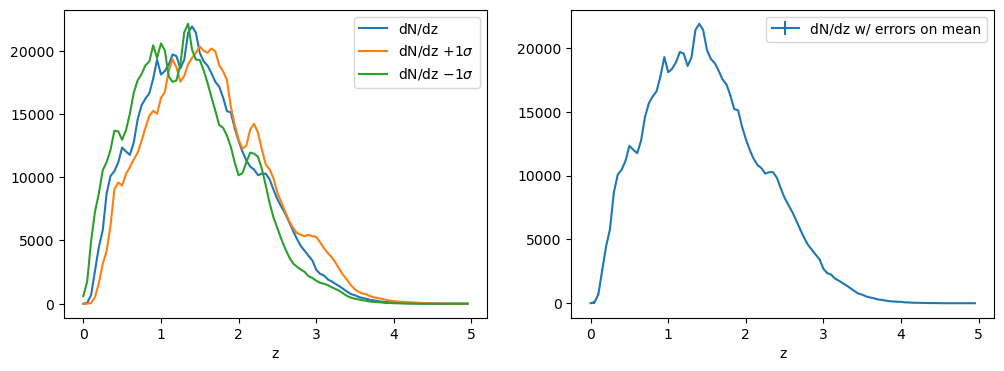

median error on bin 0.00438224954696434


/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_97553/2029970345.py:21: RuntimeWarning: divide by zero encountered in divide
  print("median error on bin",np.median(dndz_err/np.sqrt(dndz)/dndz))


In [178]:
nbins_z=100
dndz,z_ = np.histogram(z,bins=nbins_z,density=False,range=(0,5))
dndz_p1sigma = np.histogram(z+zerr,bins=nbins_z,density=False,range=(0,5))[0]
dndz_m1sigma = np.histogram(z-zerr,bins=nbins_z,density=False,range=(0,5))[0]
dndz_err = 0.5*np.abs((dndz_p1sigma-dndz_m1sigma))


pl.figure(figsize=(12,4))
pl.subplot(121)
pl.plot(z_[:-1],dndz,label='dN/dz')
pl.plot(z_[:-1],dndz_p1sigma,label='dN/dz $+1\sigma$')
pl.plot(z_[:-1],dndz_m1sigma,label='dN/dz $-1\sigma$')
pl.legend()
pl.xlabel('z')

pl.subplot(122)
pl.errorbar(z_[:-1],dndz,dndz_err/np.sqrt(dndz),label='dN/dz w/ errors on mean')
pl.xlabel('z')
pl.legend()
pl.show()
print("median error on bin",np.median(dndz_err/np.sqrt(dndz)/dndz))

## dN/dz error from bootstrap

In [139]:
nreal = 1000
bootstrap_frac = 0.10
bootstrap_nqso = int(bootstrap_frac *nqso)
dndz_list = []
idx=np.arange(nqso,dtype=np.int64)
for i in range(nreal):
    np.random.shuffle(z)
    np.random.shuffle(idx)
    myz = np.array(z)
    myz[-bootstrap_nqso:] = z[idx[:bootstrap_nqso]]
    dndz_ith = np.histogram(myz,bins=100,density=True,range=(0,5))
    dndz_list.append(dndz_ith[0])
z_hist =  dndz_ith[1]

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_97553/4249454922.py:2: RuntimeWarning: invalid value encountered in divide
  frac_err = np.std(dndz_list,axis=0)/np.mean(dndz_list,axis=0)


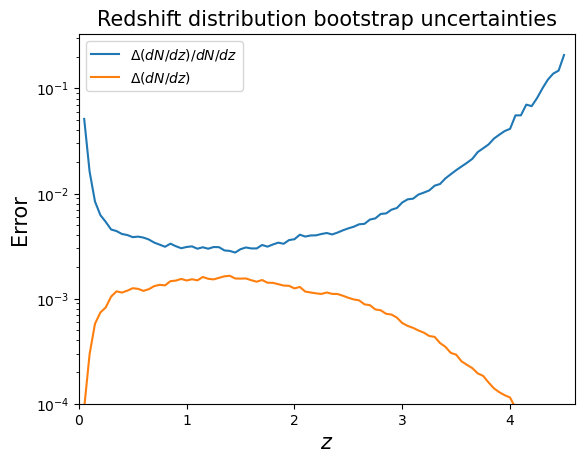

Mean/Median frac. error dN/dz 0.019567286533789224 0.004746244741164331
Mean/Median error dN/dz 0.0007745515310594422 0.0008070068544402917


In [70]:
err = np.std(dndz_list,axis=0)
frac_err = np.std(dndz_list,axis=0)/np.mean(dndz_list,axis=0)
frac_err_mask = frac_err==frac_err
z_hist =  dndz_ith[1][:-1]

pl.semilogy(z_hist[frac_err_mask],frac_err[frac_err_mask],label='$\Delta(dN/dz)/dN/dz$')
pl.semilogy(z_hist,np.std(dndz_list,axis=0),label='$\Delta(dN/dz)$')
pl.ylim(1e-04,None)
pl.legend()
pl.xlim(0,4.6)
pl.xlabel('$z$',size=15)
pl.ylabel('Error',size=15)
pl.title("Redshift distribution bootstrap uncertainties",size=15)
pl.show()
print("Mean/Median frac. error dN/dz",np.mean(frac_err[frac_err_mask]),np.median(frac_err[frac_err_mask]))
print("Mean/Median error dN/dz",np.mean(err),np.median(err))
#pl.errorbar(z_hist[:-1],np.mean(dndz_list,axis=0),np.std(dndz_list,axis=0))

# Magnification bias error

In [96]:
#cat = fits.open('../../catalog_20230406/catalog_G20.5.fits')
cat = fits.open('../../catalog_20230406/QUaia_G20.6.fits')
nqso = len(cat[1].data['phot_g_mean_mag'])

In [99]:
nreal=1000
bootstrap_frac = 0.20
bootstrap_nqso = int(bootstrap_frac *nqso)

for mcut in [20,20.5]:
    g = np.array(cat[1].data['phot_g_mean_mag'])
    idx=np.arange(len(g),dtype=np.int64)
    s_list=[]
    nbins=500
    #mcut=20.0
    for i in range(nreal+1):
        if i==nreal:
            print("Analysis full sample",i)
            g = np.array(cat[1].data['phot_g_mean_mag'])
            idx=np.arange(len(g),dtype=np.int64)        
            myg=np.array(g)
        else:
            np.random.shuffle(g)
            np.random.shuffle(idx)
            myg = np.array(g)
            myg[-bootstrap_nqso:] = g[idx[:bootstrap_nqso]]
        
        #print(idx[:bootstrap_nqso],myg[-bootstrap_nqso:])
        
        dNdm_all=np.histogram(myg,bins=nbins,range=(4,22))
        mstep = np.diff(dNdm_all[1])[0]
        N_all=dNdm_all[0]
        xm = dNdm_all[1][:-1]+mstep/2
        s_all= np.gradient(np.log10(np.cumsum(N_all)),mstep)
        if i==nreal: 
            print("Mag bias full sample",np.interp(mcut,xm,s_all))
        else:
            s_list.append(np.interp(mcut,xm,s_all))
    print("Mcut",mcut,"Bootstrap mean/err/frac.error",np.mean(s_list),np.std(s_list),np.std(s_list)/np.mean(s_list))

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_51655/4066265535.py:34: RuntimeWarning: divide by zero encountered in log10
  s_all= np.gradient(np.log10(np.cumsum(N_all)),mstep)


Analysis full sample 1000
Mag bias full sample 0.5121879754814922
Mcut 20 Bootstrap mean/err/frac.error 0.5122847630057036 0.0010716287100966731 0.002091861377662607
Analysis full sample 1000
Mag bias full sample 0.3959065962493293
Mcut 20.5 Bootstrap mean/err/frac.error 0.3959036974913182 0.0006964169269568337 0.0017590563851000798


Text(0.5, 0, 's [m*=20.5]')

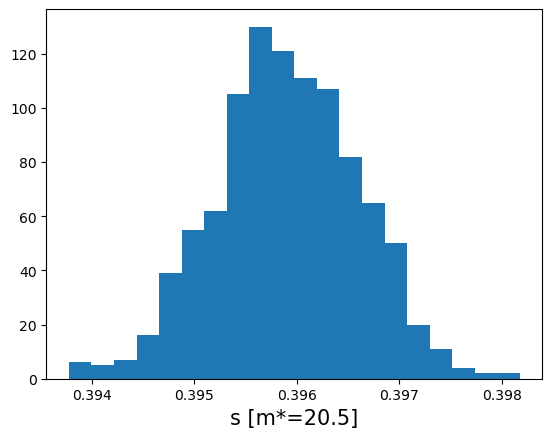

In [103]:
pl.hist(s_list,bins=20)
pl.xlabel('s [m*=%.1f]'%mcut,size=15)